In [1]:
# Cell 0: Install dependencies (run once)
!pip install --quiet \
    numpy==1.23.5 \
    opencv-python \
    pillow \
    pytesseract \
    pyocr \
    tensorflow \
    scikit-learn \
    matplotlib \
    albumentations \
    requests \
    requests-cache \
    tenacity \
    easyocr


In [3]:
import sys
import os

# Add the project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


In [4]:
# Cell 1: Setup & Imports

# For notebook display and reproducibility
%matplotlib inline
import random
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Your package modules
from model import SETINFO
from model.prediction import card_prediction_processing, card_ocr_crop, get_card_info
from model.modelling import build_cnn, symbols_model
from model.text_detection import get_pokeid, _preprocess_corner
from model.augmentation import get_augment_data

# Fix random seeds (optional)
random.seed(25)
np.random.seed(25)

print("Setup complete. SETINFO keys:", SETINFO[:,0])


Setup complete. SETINFO keys: ['dv1' 'swsh9' 'swsh45' 'swsh6' 'swsh12pt5' 'xy1' 'xy2' 'xy3' 'g1' 'xy4'
 'xy6' 'xy7' 'dp1' 'dp2' 'sm4' 'swsh10' 'sv4' 'sv3pt5' 'sv3' 'sv2']


URL: https://images.pokemontcg.io/dp1/4_hires.png
Set: dp1 | Index: 4


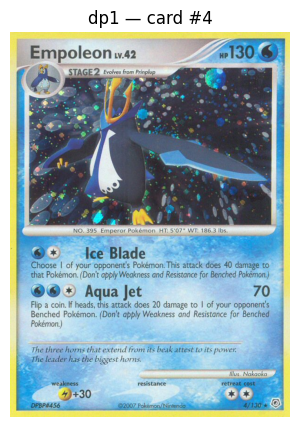

In [3]:
# Cell 2: Fetch & Display a Random Card Image

# 1. Pick a random set and a random card index
sets = SETINFO[:, 0]
set_id = random.choice(sets)
total = int(SETINFO[SETINFO[:, 0] == set_id, 1][0])
card_index = random.randint(1, total)

# 2. Build URL and download
url = f"https://images.pokemontcg.io/{set_id}/{card_index}_hires.png"
response = requests.get(url, stream=True)
card_img = Image.open(response.raw).convert("RGB")

# 3. Display
plt.figure(figsize=(4,5))
plt.imshow(card_img)
plt.axis('off')
plt.title(f"{set_id} — card #{card_index}")

# 4. Print out which card we grabbed
print("URL:", url)
print("Set:", set_id, "| Index:", card_index)

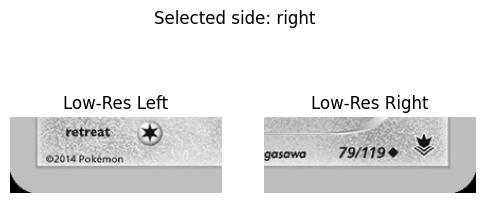

In [18]:
# Cell 3: Low-Res Corner Crops

import numpy as np
import matplotlib.pyplot as plt
from model import SETINFO
from model.prediction import card_prediction_processing

# Convert PIL → NumPy array
card_np = np.array(card_img)

# Produce the two 72×200 grayscale crops (float32 in [0,1])
low_left, low_right = card_prediction_processing(card_np)

# Determine which side contains the set info
side = SETINFO[SETINFO[:,0] == set_id, 3][0]  # 'left' or 'right'

# Squeeze off the singleton dims for plotting
patch_left  = low_left .squeeze()
patch_right = low_right.squeeze()

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(patch_left,  cmap='gray')
axes[0].set_title("Low-Res Left")
axes[0].axis('off')
axes[1].imshow(patch_right, cmap='gray')
axes[1].set_title("Low-Res Right")
axes[1].axis('off')
plt.suptitle(f"Selected side: {side}")
plt.show()


(-0.5, 199.5, 71.5, -0.5)

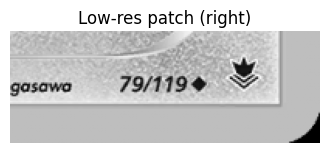

In [19]:
# Cell 3.1: Display only the low-res corner patch
from model.prediction import card_prediction_processing

# get both corners
low_left, low_right = card_prediction_processing(card_np)
side = SETINFO[SETINFO[:,0] == set_id, 3][0]
patch = (low_left if side == "left" else low_right).squeeze()

plt.figure(figsize=(4,3))
plt.imshow(patch, cmap="gray")
plt.title(f"Low-res patch ({side})")
plt.axis("off")


(-0.5, 599.5, 215.5, -0.5)

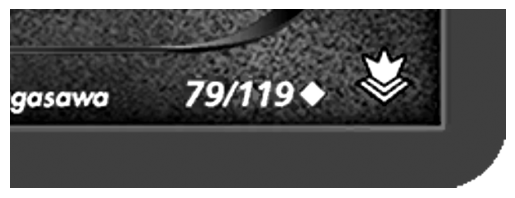

In [22]:
pil_crop = _preprocess_corner(card_np, set_id)
plt.imshow(pil_crop, cmap='gray'); plt.axis('off')


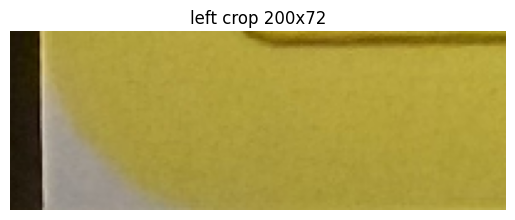

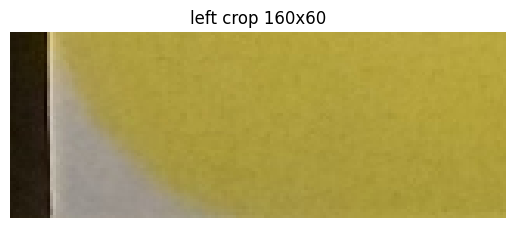

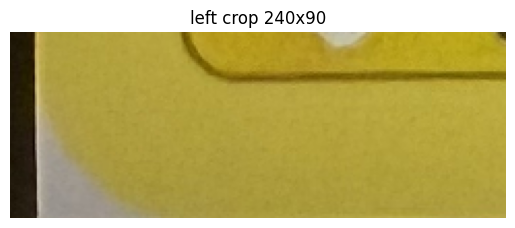

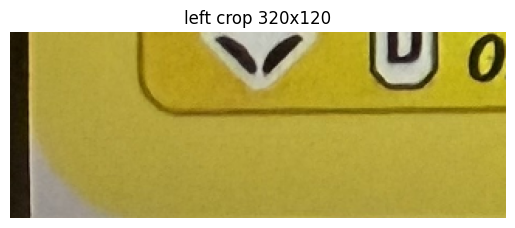

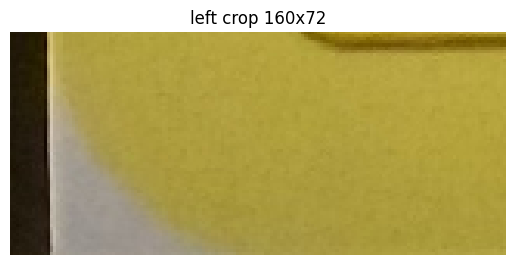

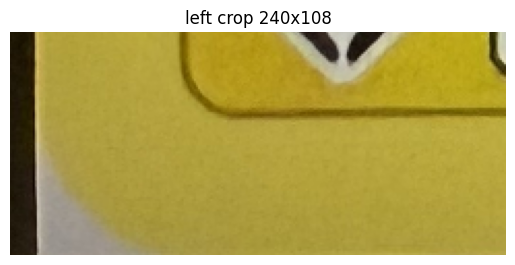

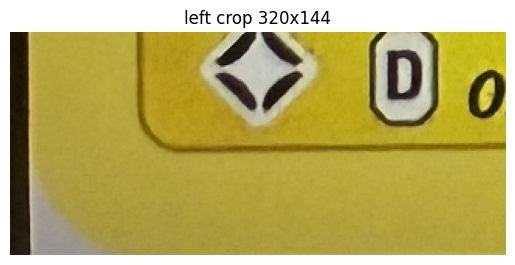

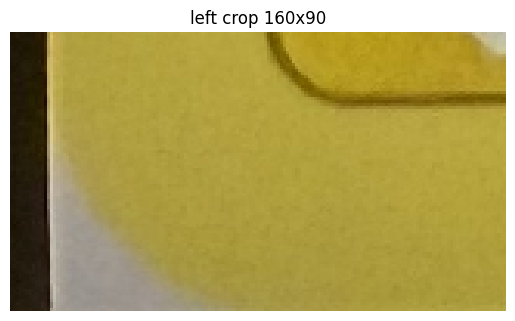

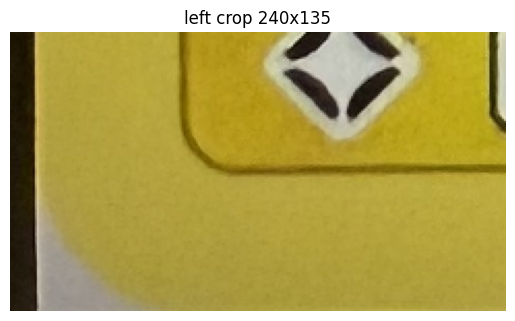

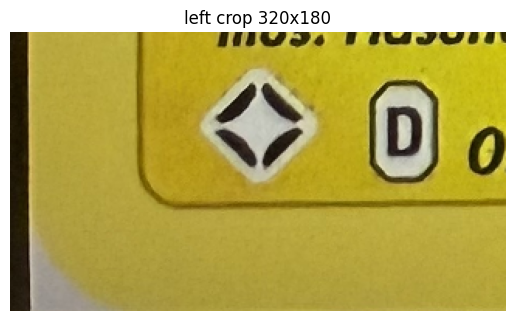

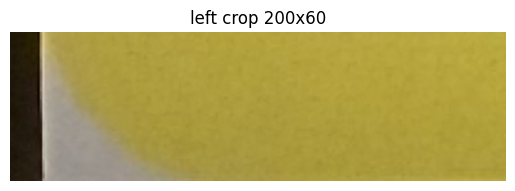

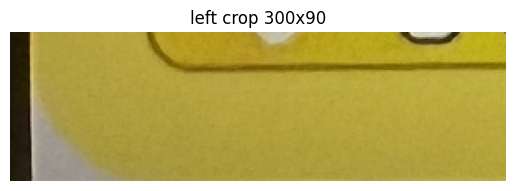

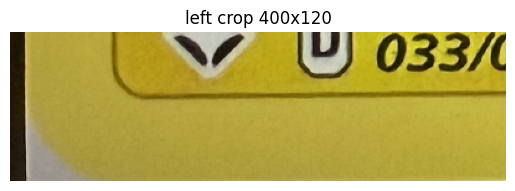

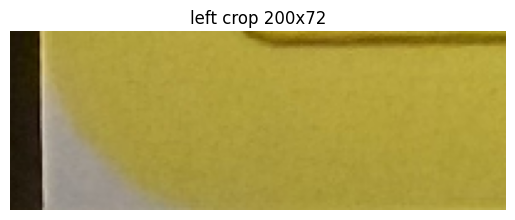

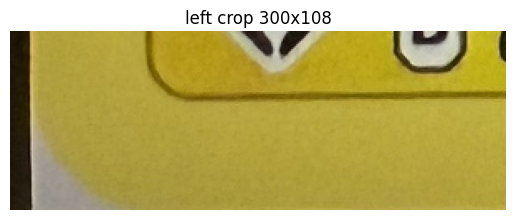

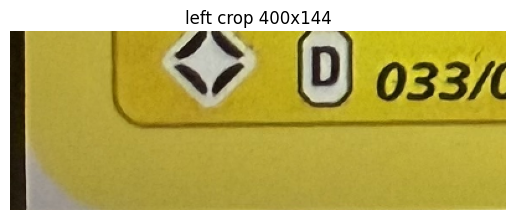

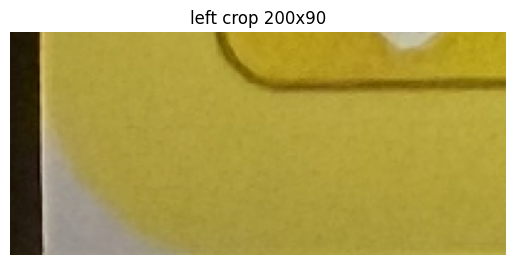

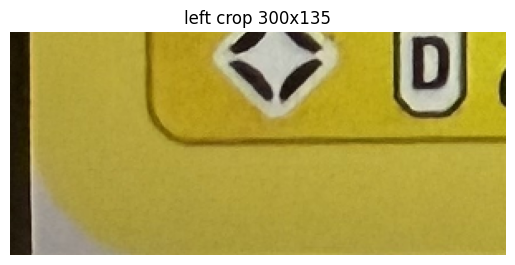

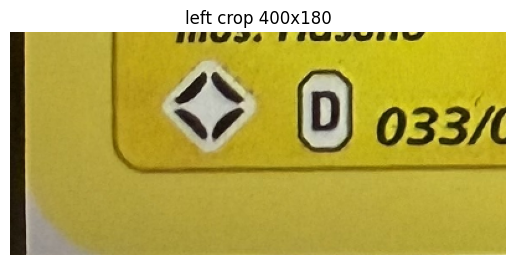

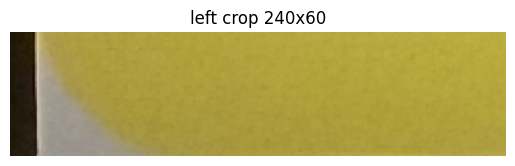

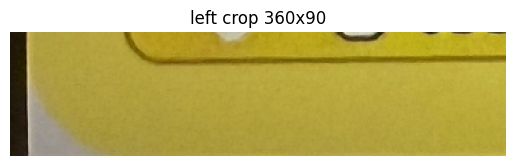

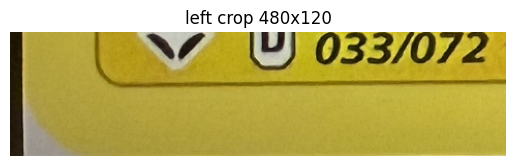

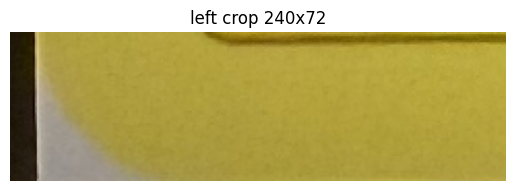

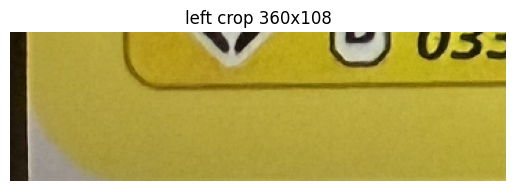

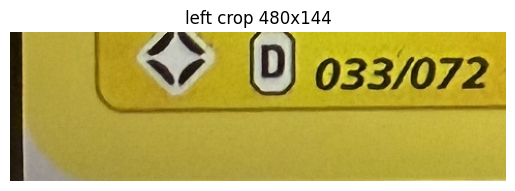

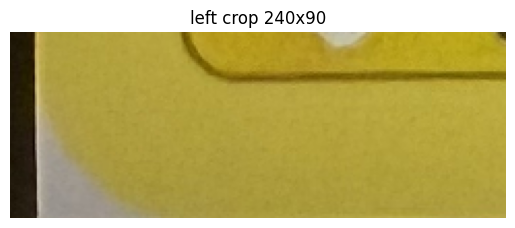

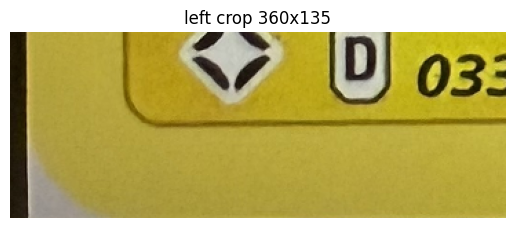

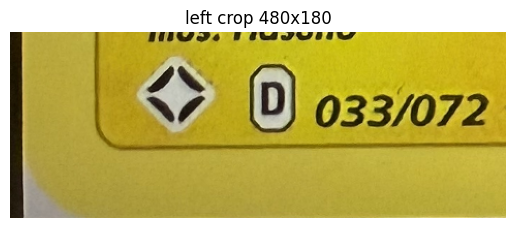

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from model.deformer import deform_card

def flexible_corner_crop(
    card_img, side='left',
    hires_w=1800, hires_h=2475,
    crop_w=200, crop_h=72,
    ratio=1, visualize=True
):
    card_img = cv2.resize(card_img, (hires_w, hires_h))
    h, w = hires_h, hires_w
    ch, cw = int(crop_h * ratio), int(crop_w * ratio)
    if side == 'left':
        crop = card_img[h-ch:h, 0:cw]
    else:
        crop = card_img[h-ch:h, w-cw:w]
    if visualize:
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(f"{side} crop {cw}x{ch}")
        plt.axis('off')
        plt.show()
    return crop

# --- Load a test card ---
img_path = "../images_example/IMG_9401.jpg"
pil_img = Image.open(img_path).convert("RGB")
aligned_card = deform_card(pil_img)
card_np = np.array(aligned_card)
card_bgr = cv2.cvtColor(card_np, cv2.COLOR_RGB2BGR)

# --- 1. Test standard values ---
flexible_corner_crop(card_bgr, side='left', hires_w=1800, hires_h=2475, crop_w=200, crop_h=72, ratio=1, visualize=True)

# --- 2. Test a range of widths, heights, ratios ---
crop_ws = [160, 200, 240]
crop_hs = [60, 72, 90]
ratios = [1, 1.5, 2]

for w in crop_ws:
    for h in crop_hs:
        for r in ratios:
            flexible_corner_crop(card_bgr, side='left', crop_w=w, crop_h=h, ratio=r, visualize=True)


In [7]:
# Cell 3.2: Raw OCR on the 72×200 patch
import easyocr
reader = easyocr.Reader(["en"], gpu=False, verbose=False)

img3 = cv2.cvtColor((patch*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
results = reader.readtext(img3, allowlist="0123456789/", batch_size=1)
print("EasyOCR raw:", results)


EasyOCR raw: [([[99, 39], [143, 39], [143, 55], [99, 55]], '4/130', 0.9294570726875395)]


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [8]:
from model.text_detection import get_pokeid
poke_id = get_pokeid(card_np, set_id)
poke_id

'0'

In [12]:
# Cell 6: Fetch card info from the PokéTCG API

from model.prediction import get_card_info

# 1) We already have `set_id` (either your ground-truth or model’s prediction)
# 2) And you just extracted `poke_id` via get_pokeid()
print(f"Looking up info for set={set_id!r}, card={poke_id!r}…")

info = get_card_info(set_id, poke_id)
if info is None:
    print("⚠️  API lookup failed.")
else:
    rarity, market_price, image_url = info
    print(f"Rarity:       {rarity}")
    print(f"Avg. Price:   ${market_price:.2f}")
    print(f"Card image:   {image_url}")


2025-05-30 14:39:07,248 [INFO] model.prediction: Fetching card info from https://api.pokemontcg.io/v2/cards/sv4-180


Looking up info for set='sv4', card='180'…
Rarity:       Uncommon
Avg. Price:   $0.05
Card image:   https://images.pokemontcg.io/sv4/180_hires.png


# using gemini ocr instead


In [5]:
# Fix random seeds (optional)
random.seed(30)
np.random.seed(30)

print("Setup complete. SETINFO keys:", SETINFO[:,0])

Setup complete. SETINFO keys: ['dv1' 'swsh9' 'swsh45' 'swsh6' 'swsh12pt5' 'xy1' 'xy2' 'xy3' 'g1' 'xy4'
 'xy6' 'xy7' 'dp1' 'dp2' 'sm4' 'swsh10' 'sv4' 'sv3pt5' 'sv3' 'sv2']


URL: https://images.pokemontcg.io/xy4/79_hires.png
Set: xy4 | Index: 79


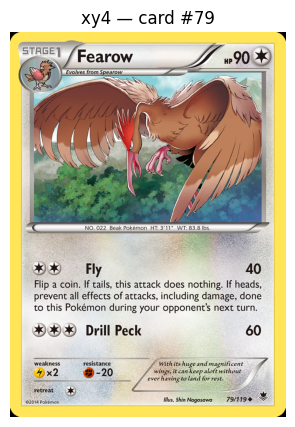

In [7]:
# Cell 2: Fetch & Display a Random Card Image

# 1. Pick a random set and a random card index
sets = SETINFO[:, 0]
set_id = random.choice(sets)
total = int(SETINFO[SETINFO[:, 0] == set_id, 1][0])
card_index = random.randint(1, total)

# 2. Build URL and download
url = f"https://images.pokemontcg.io/{set_id}/{card_index}_hires.png"
response = requests.get(url, stream=True)
card_img = Image.open(response.raw).convert("RGB")

# 3. Display
plt.figure(figsize=(4,5))
plt.imshow(card_img)
plt.axis('off')
plt.title(f"{set_id} — card #{card_index}")

# 4. Print out which card we grabbed
print("URL:", url)
print("Set:", set_id, "| Index:", card_index)

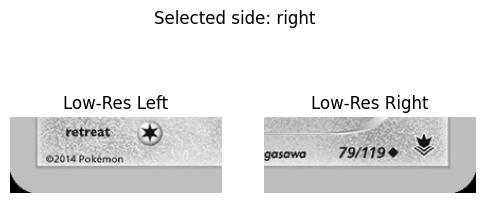

In [8]:
# Cell 3: Low-Res Corner Crops

import numpy as np
import matplotlib.pyplot as plt
from model import SETINFO
from model.prediction import card_prediction_processing

# Convert PIL → NumPy array
card_np = np.array(card_img)

# Produce the two 72×200 grayscale crops (float32 in [0,1])
low_left, low_right = card_prediction_processing(card_np)

# Determine which side contains the set info
side = SETINFO[SETINFO[:,0] == set_id, 3][0]  # 'left' or 'right'

# Squeeze off the singleton dims for plotting
patch_left  = low_left .squeeze()
patch_right = low_right.squeeze()

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(patch_left,  cmap='gray')
axes[0].set_title("Low-Res Left")
axes[0].axis('off')
axes[1].imshow(patch_right, cmap='gray')
axes[1].set_title("Low-Res Right")
axes[1].axis('off')
plt.suptitle(f"Selected side: {side}")
plt.show()

(-0.5, 199.5, 71.5, -0.5)

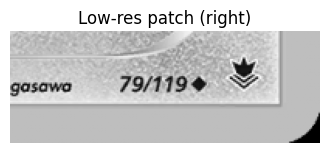

In [9]:
# Cell 3.1: Display only the low-res corner patch
from model.prediction import card_prediction_processing

# get both corners
low_left, low_right = card_prediction_processing(card_np)
side = SETINFO[SETINFO[:,0] == set_id, 3][0]
patch = (low_left if side == "left" else low_right).squeeze()

plt.figure(figsize=(4,3))
plt.imshow(patch, cmap="gray")
plt.title(f"Low-res patch ({side})")
plt.axis("off")


In [16]:
!pip install google-generativeai


  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.1 MB/s eta 0:00:00
Using cached cachetools-5.5.2-py3-none-any.whl (10 kB)
Using cached rsa-4.9.1-py3-none-any.whl (34 kB)
Using cached pyasn1-0.6.1-py3-none-any.whl (83 kB)
Using cached pyasn1_modules-0.4.2-py3-none-any.whl (181 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 6.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.7
    Uninstalling protobuf-4.25.7:
      Successfully uninstalled protobuf-4.25.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16/16 [google-generativeai]ogle-ai-generativelanguage]
ERROR: pip's dependency resolver does not currently take into account all the packages that are inst

In [10]:
import google.generativeai as genai
import os
from google.generativeai.types import HarmCategory, HarmBlockThreshold

/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Step 1: Set your key
os.environ['GEMINI_AI_API_KEY'] = ''

# Step 2: Use it in your code
API_KEY = os.environ['GEMINI_AI_API_KEY']
genai.configure(api_key=API_KEY)


In [11]:
from PIL import Image
import numpy as np

def save_patch_to_jpg(patch, out_path="temp_patch.jpg"):
    # Ensure 3 channels for jpg
    if patch.ndim == 2:
        patch = np.stack([patch]*3, axis=-1)
    Image.fromarray(patch).save(out_path)
    return out_path


In [12]:
def prep_image(image_path):
    # Upload the file and print a confirmation.
    sample_file = genai.upload_file(path=image_path,
                                display_name="Diagram")
    print(f"Uploaded file '{sample_file.display_name}' as: {sample_file.uri}")
    file = genai.get_file(name=sample_file.name)
    print(f"Retrieved file '{file.display_name}' as: {sample_file.uri}")
    return sample_file

In [13]:
def extract_text_from_image(image_path, prompt):
    # Choose a Gemini model.
    model = genai.GenerativeModel(model_name="gemini-1.5-pro")
    # Prompt the model with text and the previously uploaded image.
    response = model.generate_content([image_path, prompt])
    return response.text

In [ ]:
def compare_ocr_on_patch(patch, prompt="Extract the card number, e.g. '32/100'"):
    # EasyOCR
    ocr_reader = easyocr.Reader(["en"], gpu=False, verbose=False)
    easyocr_result = ocr_reader.readtext(patch, allowlist="0123456789/", batch_size=1)
    print("EasyOCR:", easyocr_result)

    # Save for Gemini
    patch_path = save_patch_to_jpg(patch)
    sample_file = prep_image(patch_path)
    gemini_text = extract_text_from_image(sample_file, prompt)
    print("Gemini OCR:", gemini_text)
    return easyocr_result, gemini_text


In [39]:
gray2 = _preprocess_corner(card_np, set_id)
up2   = cv2.resize(gray2, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
_, bw = cv2.threshold(up2, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
bgr2  = cv2.cvtColor(bw, cv2.COLOR_GRAY2BGR)

# Compare both OCR methods!
compare_ocr_on_patch(bgr2)


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


EasyOCR: [([[0, 181], [249, 181], [249, 261], [0, 261]], '95', 0.6591784051494913), ([[416, 162], [767, 162], [767, 251], [416, 251]], '79/1190', 0.787892291235898)]
Uploaded file 'Diagram' as: https://generativelanguage.googleapis.com/v1beta/files/rziqvpdrce5v
Retrieved file 'Diagram' as: https://generativelanguage.googleapis.com/v1beta/files/rziqvpdrce5v


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_input_token_count"
  quota_id: "GenerateContentInputTokensPerModelPerMinute-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
}
violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
}
violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 14
}
]

In [ ]:
import google.generativeai as genai
import os

os.environ['GOOGLE_API_KEY'] = ""
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])

model = genai.GenerativeModel(model_name="gemini-1.5-pro")
response = model.generate_content("Say hello from Gemini Vision!")
print(response.text)


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
}
violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
}
violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_input_token_count"
  quota_id: "GenerateContentInputTokensPerModelPerMinute-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 27
}
]

In [ ]:
# Cell 6: Fetch card info from the PokéTCG API

from model.prediction import get_card_info

# 1) We already have `set_id` (either your ground-truth or model’s prediction)
# 2) And you just extracted `poke_id` via get_pokeid()
print(f"Looking up info for set={set_id!r}, card={poke_id!r}…")

info = get_card_info(set_id, poke_id)
if info is None:
    print("⚠️  API lookup failed.")
else:
    rarity, market_price, image_url = info
    print(f"Rarity:       {rarity}")
    print(f"Avg. Price:   ${market_price:.2f}")
    print(f"Card image:   {image_url}")
